In [1]:
import pandas as pd
import numpy as np
import json
import joblib

import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.pipeline import make_pipeline
import pickle
import joblib


In [2]:
df = pd.read_csv('data/data.csv')
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [3]:
def drop_duplicates_and_null(data):
    
    data_ = data.copy()
    data_.drop_duplicates(inplace=True)
    data_.dropna(inplace=True)

    return data_


df_train = drop_duplicates_and_null(df_train)
df_test = drop_duplicates_and_null(df_test)


In [4]:
X_train = df_train.drop(columns='ContrabandIndicator')
y_train = df_train['ContrabandIndicator']

X_test = df_test.drop(columns='ContrabandIndicator')
y_test = df_test['ContrabandIndicator']

In [5]:
class SelectFeatures(BaseEstimator, TransformerMixin):
    def fit(self, *_):
        return self
    
    def transform(self, data):
        
        data_ = data.copy()
        #Drop features
        
        data_ = data_[[ 'InterventionDateTime','InterventionLocationName', 'SearchAuthorizationCode', 'SubjectAge']]

        return data_
    
class DateTimeTransform(BaseEstimator, TransformerMixin):
    def fit(self, *_):
        return self
    
    def transform(self, data):   
    
        
        data_ = data.copy()
        
        #Conversion to DateTime type
        data_.InterventionDateTime = pd.to_datetime(data_.InterventionDateTime, format='%m/%d/%Y %I:%M:%S %p')
    
        #Creating time features
        data_ = data_.assign(HourDay = data_.InterventionDateTime.dt.hour + data_.InterventionDateTime.dt.minute / 60,
                       Month = data_.InterventionDateTime.dt.month)
        
        #Further transformation on HourDay
        data_['HourDay'] = data_['HourDay'].apply(lambda x: round(x,1)).apply(lambda x: 0.0 if  x==24.0 else x)

        #Drop inital DateTime column
        data_ = data_.drop(columns='InterventionDateTime')
        
        return data_
    
class InterventionLocationTransform( TransformerMixin):
    def fit(self, *_):
        return self
    
    def transform(self, data):   
    
        data_ = data.copy()
    
        data_.InterventionLocationName = data_.InterventionLocationName.str.lower().str.strip()
        data_.InterventionLocationName = data_.InterventionLocationName.str.replace('street', 'st')
        data_.InterventionLocationName = data_.InterventionLocationName.str.replace('road', 'rd')
        data_.InterventionLocationName = data_.InterventionLocationName.str.replace('  ', '')
        
        return data_
    
class AgeTransform(TransformerMixin):
    
    def fit(self, *_):
        return self
    
    def transform(self, data):   
        
        data_ = data.copy()
        
        data_.loc[data_.SubjectAge < 14, 'SubjectAge'] = 12.0

        return data_

In [7]:
pipeline = make_pipeline(
    SelectFeatures(),
    DateTimeTransform(),
    InterventionLocationTransform(),
    AgeTransform(),
    BinaryEncoder(),
    RandomForestClassifier(n_estimators=20, max_depth= 10))

In [8]:
%%time

pipeline.fit(X_train, y_train)

C:\Users\ines.s.almeida\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Wall time: 1min 19s


Pipeline(steps=[('selectfeatures', SelectFeatures()),
                ('datetimetransform', DateTimeTransform()),
                ('interventionlocationtransform',
                 <__main__.InterventionLocationTransform object at 0x00000126C790CE80>),
                ('agetransform',
                 <__main__.AgeTransform object at 0x00000126C790C910>),
                ('binaryencoder', BinaryEncoder()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, n_estimators=20))])

In [9]:
pred = pipeline.predict_proba(X_test)

In [10]:
y_pred = (pred[:,1] >= 0.45)


print('Precision score:', round(precision_score(y_test,y_pred),2))
print('Recall score:', round(recall_score(y_test,y_pred),2))
print('Accuracy score:', round(accuracy_score(y_test,y_pred),2))

Precision score: 0.63
Recall score: 0.4
Accuracy score: 0.99


### Assessing fairness

In [11]:
def preprocess_data_fairness(data, predictions):
    
    data_ = data.copy()
    
    data_ = drop_duplicates_and_null(data_)
    
    
    data_final = data_[[ 'SubjectEthnicityCode', 'SubjectRaceCode', 'SubjectSexCode']]
    data_final['y'] = data_['ContrabandIndicator']
    data_final['y_pred'] = predictions
    
    return data_final

df_fairness = preprocess_data_fairness(df_test, y_pred)

<ipython-input-11-3927603d4373>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['y'] = data_['ContrabandIndicator']
<ipython-input-11-3927603d4373>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['y_pred'] = predictions


In [12]:
def plot_precision(df , protected_class):
    
    TP = df[(df.y_pred == 1) & (df.y == 1)]
    FP = df[(df.y_pred == 1) & (df.y == 0)]

    prec = TP.groupby(TP[protected_class])[protected_class].count()/(FP.groupby(FP[protected_class])[protected_class].count() + TP.groupby(TP[protected_class])[protected_class].count())
    plt.figure(figsize=(15, 5))
    pal = sns.color_palette("Reds_d", len(prec))

    sns.barplot(prec.index, prec.values)


    ax = sns.barplot(prec.index, prec.values, palette=np.array(pal[::-1]))

    ax.set(xlabel=protected_class, ylabel='Precision')
    plt.show()
    
    print(prec)

C:\Users\ines.s.almeida\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ines.s.almeida\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


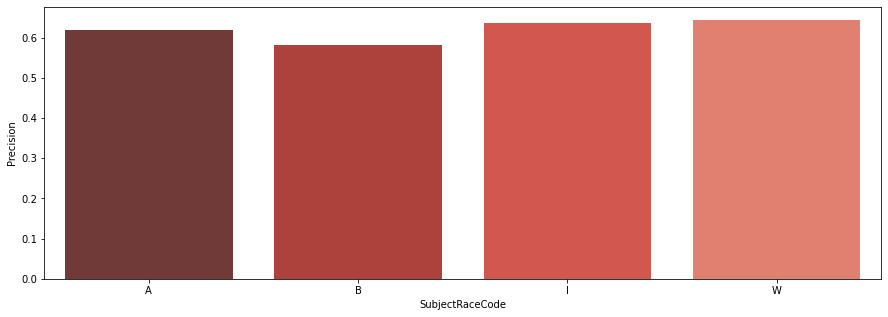

SubjectRaceCode
A    0.619048
B    0.582278
I    0.636364
W    0.644287
Name: SubjectRaceCode, dtype: float64


In [13]:
plot_precision(df_fairness, 'SubjectRaceCode')

C:\Users\ines.s.almeida\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ines.s.almeida\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


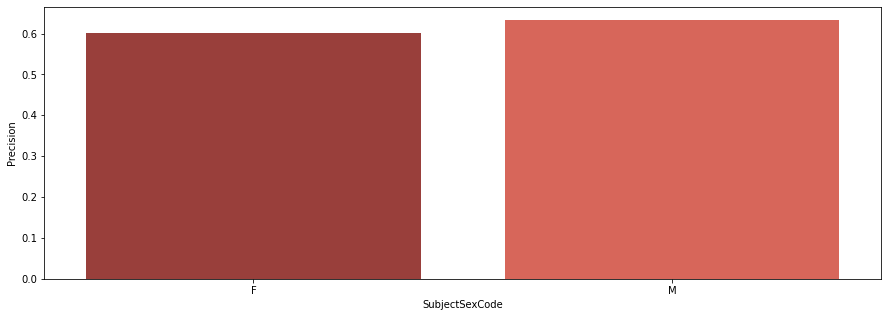

SubjectSexCode
F    0.602118
M    0.633287
Name: SubjectSexCode, dtype: float64


In [14]:
plot_precision(df_fairness, 'SubjectSexCode')

C:\Users\ines.s.almeida\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ines.s.almeida\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


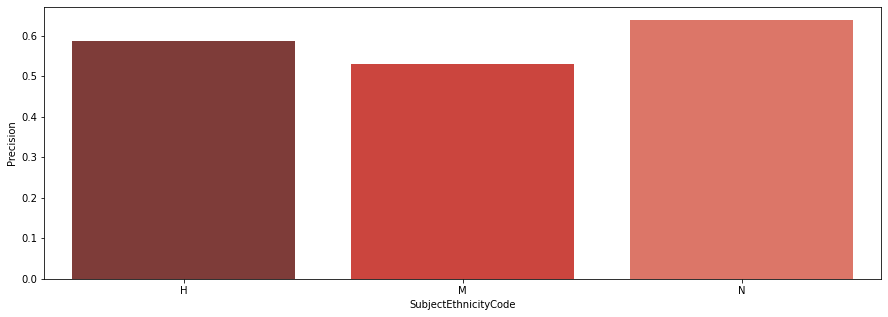

SubjectEthnicityCode
H    0.586552
M    0.531250
N    0.638770
Name: SubjectEthnicityCode, dtype: float64


In [15]:
plot_precision(df_fairness, 'SubjectEthnicityCode')

In [16]:
with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)

In [17]:
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)

In [18]:
joblib.dump(pipeline, 'pipeline.pickle')

['pipeline.pickle']